Example workflow using pycaret, and Jimmy's "utility_forecast_analysis.ipynb"

Author: Hayden Fiege
Date: March 29 2021

In [1]:
import pandas as pd
import numpy as np
from math import log10
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from weather_scrape import *
from electricity_scrape import * 


Import weather_scrape.py and electricity_scrape.py files containing functions to scrape data

In [2]:
# weather params
city = 'yyc'
startdate = '2000-01-01'
enddate = '2020-12-31'
dateformat = '%Y-%m-%d'
contenttype = 'html'
#get raw data into pd dataframe, timeframe = 2 is daily data
weather_df  =  weather_dl_range(startdate, enddate, dateformat, city, 2, clean=True)

Getting data for YYC, station ID 50430
downloading daily data for year 2000
data for year 2000 downloaded
sleep for 3 seconds
downloading daily data for year 2001
data for year 2001 downloaded
sleep for 7 seconds
downloading daily data for year 2002
data for year 2002 downloaded
sleep for 7 seconds
downloading daily data for year 2003
data for year 2003 downloaded
sleep for 9 seconds
downloading daily data for year 2004
data for year 2004 downloaded
sleep for 8 seconds
downloading daily data for year 2005
data for year 2005 downloaded
sleep for 3 seconds
downloading daily data for year 2006
data for year 2006 downloaded
sleep for 5 seconds
downloading daily data for year 2007
data for year 2007 downloaded
sleep for 5 seconds
downloading daily data for year 2008
data for year 2008 downloaded
sleep for 4 seconds
downloading daily data for year 2009
data for year 2009 downloaded
sleep for 7 seconds
downloading daily data for year 2010
data for year 2010 downloaded
sleep for 4 seconds
down

Run function "aeso_download_range" to scrape electricity daily average pool prices for time range

In [3]:
#electricity params
tablename = 'DailyAveragePoolPrice'
startdate = '2000-01-01'
enddate = '2020-12-31'
dateformat = '%Y-%m-%d'
contenttype = 'html'
#get table of downloaded data, sort by date
util_prices = aeso_download_range(tablename, contenttype, startdate, enddate, dateformat).sort_values(by='$/MWh_Date').reset_index()

iceReportServlet?beginDate=03182016&endDate=04172016&contentType=html
2016-03-18 00:00:00downloaded
sleep for 7 seconds
converted date string from 2016-04-18 00:00:00 to datetime value 04182016
converted date string from 2016-05-18 00:00:00 to datetime value 05182016
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolPriceReportServlet?beginDate=04182016&endDate=05182016&contentType=html
2016-04-18 00:00:00downloaded
sleep for 6 seconds
converted date string from 2016-05-19 00:00:00 to datetime value 05192016
converted date string from 2016-06-18 00:00:00 to datetime value 06182016
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolPriceReportServlet?beginDate=05192016&endDate=06182016&contentType=html
2016-05-19 00:00:00downloaded
sleep for 9 seconds
converted date string from 2016-06-19 00:00:00 to datetime value 06192016
converted date string from 2016-07-19 00:00:00 to datetime value 07192016
download url generated




Join weather data and electricity price data together for analysis

In [5]:
unseen_weather_df = weather_df.iloc[6515:]
unseen_util_prices_df = util_prices.iloc[6515:]
train_weather_df = weather_df.iloc[:6514]
train_util_prices_df = util_prices.iloc[:6514]

In [6]:
#join tables together
train_df = train_util_prices_df.merge(train_weather_df, how = 'left', left_on = '$/MWh_Date', right_on = 'Date/Time')
unseen_df = unseen_util_prices_df.merge(unseen_weather_df, how = 'left', left_on = '$/MWh_Date', right_on = 'Date/Time')

Pick Daily_Average as the price to analyze (predictor label), and convert to kwh for standard consumer units Define columns used for prediction label, features and timestamp

In [7]:
train_df['Avg_Price_kwh'] = train_df['Daily_Average'] / 1000
train_df = train_df.rename(columns = {'$/MWh_Date':'Date'})

unseen_df['Avg_Price_kwh'] = unseen_df['Daily_Average'] / 1000
unseen_df = unseen_df.rename(columns = {'$/MWh_Date':'Date'})

In [8]:
print(train_df.info())
print(unseen_df.info())

print(train_df.head())
print(unseen_df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6514 entries, 0 to 6513
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   index                      6514 non-null   int64         
 1   Date                       6514 non-null   datetime64[ns]
 2   Daily_Average              6514 non-null   float64       
 3   Daily_On Peak Average      6514 non-null   float64       
 4   Daily_Off Peak Average     6514 non-null   float64       
 5   30Ravg_Average             6514 non-null   float64       
 6   30Ravg_On Peak Average     6514 non-null   float64       
 7   30Ravg_Off Peak Average    6514 non-null   float64       
 8   Date/Time                  6514 non-null   datetime64[ns]
 9   Year                       6514 non-null   int64         
 10  Month                      6514 non-null   int64         
 11  Day                        6514 non-null   int64         
 12  Max Te

In [9]:


train_df = train_df[['Date','Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
            'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
            'Dir of Max Gust (10s deg)','Avg_Price_kwh']]
unseen_df = unseen_df[['Date','Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
            'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
            'Dir of Max Gust (10s deg)','Avg_Price_kwh']]


In [10]:
dataset = train_df
#check the shape of data
dataset.shape

(6514, 14)

In [11]:

data = dataset
data_unseen = unseen_df


print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (6514, 14)
Unseen Data For Predictions: (1156, 14)


In [14]:
from pycaret.regression import *
exp_reg101 = setup(data = data, target = 'Avg_Price_kwh', session_id=1)

,Description,Value
0,session_id,1
1,Target,Avg_Price_kwh
2,Original Data,"(6514, 14)"
3,Missing Values,True
4,Numeric Features,11
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4559, 31)"


In [15]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0399,0.0045,0.0669,0.0529,0.0572,0.8718,0.0040
gbr,Gradient Boosting Regressor,0.0393,0.0045,0.0669,0.0529,0.0572,0.8434,0.0550
lr,Linear Regression,0.0400,0.0045,0.0669,0.0526,0.0573,0.8715,0.0040
ridge,Ridge Regression,0.0400,0.0045,0.0669,0.0526,0.0572,0.8715,0.0030
omp,Orthogonal Matching Pursuit,0.0402,0.0046,0.0675,0.0371,0.0577,0.8840,0.0040
lightgbm,Light Gradient Boosting Machine,0.0406,0.0046,0.0675,0.0352,0.0579,0.8632,0.0190
en,Elastic Net,0.0419,0.0048,0.0688,-0.0020,0.0590,0.9918,0.0040
llar,Lasso Least Angle Regression,0.0419,0.0048,0.0688,-0.0020,0.0590,0.9918,0.0040
lasso,Lasso Regression,0.0419,0.0048,0.0688,-0.0020,0.0590,0.9918,0.0050
huber,Huber Regressor,0.0346,0.0049,0.0698,-0.0301,0.0596,0.5364,0.0240


In [16]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [17]:
model_selected = "gbr"

In [19]:
gbr = create_model('gbr')
 

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0390,0.0039,0.0628,0.0584,0.0547,0.7655
1,0.0408,0.0043,0.0659,0.0510,0.0572,0.8438
2,0.0389,0.0039,0.0623,0.0799,0.0543,0.9087
3,0.0401,0.0048,0.0692,0.0438,0.0584,0.9382
4,0.0386,0.0044,0.0667,0.0878,0.0564,0.8511
5,0.0413,0.0058,0.0761,0.0384,0.0635,0.8118
6,0.0398,0.0051,0.0716,0.0462,0.0604,0.8137
7,0.0422,0.0050,0.0710,0.0409,0.0611,0.8417
8,0.0362,0.0037,0.0604,0.0297,0.0522,0.8535
9,0.0364,0.0040,0.0630,0.0529,0.0539,0.8062


In [20]:
tuned_gbr = tune_model(gbr)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0394,0.0039,0.0623,0.0729,0.0542,0.7939
1,0.0414,0.0044,0.0660,0.0481,0.0572,0.8750
2,0.0396,0.0039,0.0627,0.0682,0.0545,0.9488
3,0.0405,0.0048,0.0691,0.0455,0.0582,0.9520
4,0.0388,0.0046,0.0677,0.0593,0.0572,0.8567
5,0.0415,0.0059,0.0766,0.0268,0.0637,0.8344
6,0.0400,0.0051,0.0713,0.0555,0.0601,0.8567
7,0.0427,0.0050,0.0709,0.0433,0.0610,0.8613
8,0.0369,0.0036,0.0596,0.0562,0.0514,0.8935
9,0.0370,0.0041,0.0637,0.0323,0.0544,0.8657


In [29]:
plot_model(tuned_gbr)

In [30]:
plot_model(tuned_gbr, plot = 'feature')

In [31]:
plot_model(tuned_gbr, plot = 'feature')


In [32]:
predict_model(gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0380,0.0040,0.0629,0.0750,0.0543,0.8409


,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),...,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_0,Date_is_month_start_1,Avg_Price_kwh,Label
0,14.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.13903,0.076641
1,17.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.09622,0.058871
2,22.0,-1.300000,-6.200000,-3.80000,0.000000,0.0,0.8,0.8,0.0,34.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.02153,0.035369
3,21.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.02584,0.074938
4,2.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.07629,0.070169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.02879,0.051182
1951,24.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.04962,0.076066
1952,2.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.03182,0.068783
1953,13.0,11.929427,-0.194947,5.87831,0.192489,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.05072,0.067851


In [33]:

final_gbr = finalize_model(gbr)

In [34]:
unseen_predictions = predict_model(final_gbr, data=data_unseen)
unseen_predictions.head()

,Date,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Avg_Price_kwh,Label
0,2017-11-02,11,2,-4.9,-13.6,-9.3,27.3,0.0,0.0,6.0,5.4,1.0,36.0,0.02157,0.052955
1,2017-11-03,11,3,-12.8,-16.3,-14.6,32.6,0.0,0.0,6.6,6.8,8.0,34.0,0.02342,0.057853
2,2017-11-04,11,4,-11.9,-18.9,-15.4,33.4,0.0,0.0,2.2,0.9,11.0,0.0,0.03063,0.052081
3,2017-11-05,11,5,-8.5,-14.2,-11.4,29.4,0.0,0.0,0.4,0.4,10.0,34.0,0.02542,0.043670
4,2017-11-06,11,6,-8.0,-18.1,-13.1,31.1,0.0,0.0,0.0,0.0,10.0,0.0,0.02397,0.053485


<AxesSubplot:>

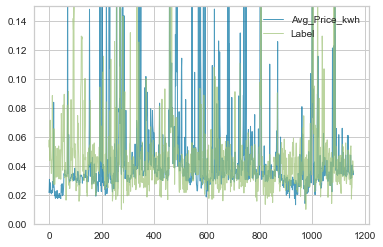

In [35]:
%matplotlib inline
unseen_predictions_label = unseen_predictions[['Avg_Price_kwh','Label']]
unseen_predictions_label.plot(ylim=[0,0.15], linewidth=1, alpha=0.7)

<AxesSubplot:>

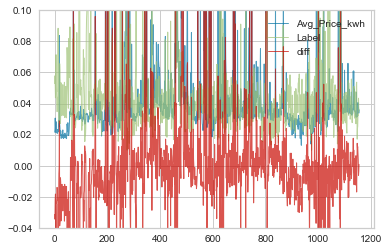

In [37]:
unseen_predictions_label['diff'] = unseen_predictions_label['Avg_Price_kwh'] - unseen_predictions_label['Label']
unseen_predictions_label.plot(ylim=[-0.04,0.10], linewidth=1, alpha=0.7)



In [38]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.Avg_Price_kwh, unseen_predictions.Label, 'R2')

0.1419

In [31]:
save_model(final_rf,'Final gbr Model 28Mar2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Avg_Price_kwh',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        max_samp